In [1]:
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas_datareader as pdd
from datetime import datetime
from meteostat import Stations, Daily
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cpf

C:\Users\maxim\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
plt.rcParams['font.size'] = 18
hfont = {'fontname':'DejaVu Serif'}

In [3]:
dr = pd.read_csv('results_group_h.csv', sep = ',', usecols = [0, 1, 2, 3], index_col = 'Trajectory')

In [4]:
s = len(dr.groupby(dr.index))
print(s)

df = dr.groupby(dr.index).filter(lambda x: len(x) >= 50)
df = df.assign(Δx = df.groupby(df.index)['x'].diff().values)
df = df.assign(Δy = df.groupby(df.index)['y'].diff().values)
df = df.dropna()
df

9200


,Frame,x,y,Δx,Δy
Trajectory,,,,,
1,1,175.268,90.580,2.106,0.743
1,2,171.117,90.103,-4.151,-0.477
1,3,171.117,90.103,0.000,0.000
1,4,171.127,88.631,0.010,-1.472
1,5,172.421,90.157,1.294,1.526
...,...,...,...,...,...
8862,1832,33.347,224.850,-0.162,-0.181
8862,1833,33.622,225.149,0.275,0.299
8862,1834,33.521,225.182,-0.101,0.033


In [5]:
kc = 4 #kurtosis cutoff

dfk = df.groupby(df.index).filter(lambda x: (x['Δx'].kurtosis() + 3) <= kc and (x['Δy'].kurtosis() + 3) <= kc)
print(dfk)
e = len(dfk.groupby(dfk.index))
print('Number of used trajectories: ' + str(e))

Δs = s - e
print('Difference in number of trajectories: ' + str(Δs))

            Frame        x        y     Δx     Δy
Trajectory                                       
1               1  175.268   90.580  2.106  0.743
1               2  171.117   90.103 -4.151 -0.477
1               3  171.117   90.103  0.000  0.000
1               4  171.127   88.631  0.010 -1.472
1               5  172.421   90.157  1.294  1.526
...           ...      ...      ...    ...    ...
8858         1840  430.178  122.234  0.700  1.485
8858         1841  433.748  122.983  3.570  0.749
8858         1842  437.941  120.703  4.193 -2.280
8858         1843  435.376  117.457 -2.565 -3.246
8858         1844  435.583  114.592  0.207 -2.865

[18599 rows x 5 columns]
Number of used trajectories: 210
Difference in number of trajectories: 8990


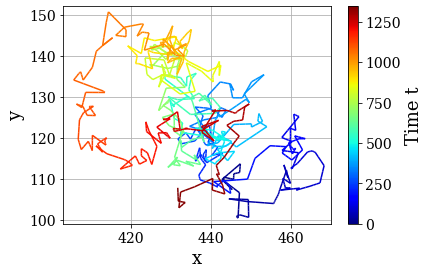

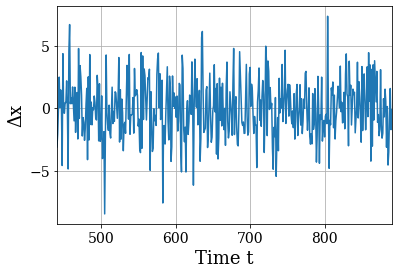

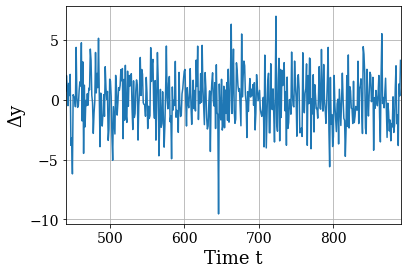

In [6]:
max_traj = dfk.groupby(dfk.index).count()['Frame'].max()
df_max = dfk.groupby(dfk.index).filter(lambda x: len(x) == max_traj)

def colorline(x, y, cmap = plt.get_cmap('jet'), linewidth = 3, alpha = 1.0):

    z = np.linspace(0.0, 1.0, len(x))
    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array = z, cmap = cmap, linewidth = linewidth, alpha = alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

x = df_max['x'].values
y = df_max['y'].values

fig, ax = plt.subplots()

path = mpath.Path(np.column_stack([x, y]))
verts = path.interpolated(steps=3).vertices
x, y = verts[:, 0], verts[:, 1]
colorline(x, y, cmap = plt.get_cmap('jet'), linewidth = 1.5)
plt.grid(True) ; plt.xlabel('x', **hfont) ; plt.ylabel('y', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
cbar = plt.colorbar(cm.ScalarMappable(norm = plt.Normalize(0.0, len(x)), cmap = plt.get_cmap('jet')))
cbar.set_label('Time t',size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.axis([403, 470, 99, 152])
plt.savefig('pics/1/longest_traj.png', dpi = 900, bbox_inches='tight')
plt.show()

df_max.plot(x = 'Frame', y = 'Δx', legend = False)
plt.grid(True) ; plt.xlabel('Time t', **hfont) ; plt.ylabel('Δx', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/series_delta_x.png', dpi = 900, bbox_inches='tight')
plt.show()

df_max.plot(x = 'Frame', y = 'Δy', legend = False)
plt.grid(True) ; plt.xlabel('Time t', **hfont) ; plt.ylabel('Δy', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/series_delta_y.png', dpi = 900, bbox_inches='tight')
plt.show()

In [7]:
mean_x = dfk.groupby(dfk.index)['Δx'].mean().mean()
mean_y = dfk.groupby(dfk.index)['Δy'].mean().mean()
var_x = dfk.groupby(dfk.index)['Δx'].var().var()
var_y = dfk.groupby(dfk.index)['Δy'].var().var()
skew_x = dfk.groupby(dfk.index)['Δx'].skew().skew()
skew_y = dfk.groupby(dfk.index)['Δy'].skew().skew()
kurt_x = dfk.groupby(dfk.index)['Δx'].apply(lambda x: sps.kurtosis(x, fisher = False)).apply(lambda x: sps.kurtosis(x, fisher = False))
kurt_y = dfk.groupby(dfk.index)['Δy'].apply(lambda x: sps.kurtosis(x, fisher = False)).apply(lambda x: sps.kurtosis(x, fisher = False))

In [8]:
dfk = dfk.assign(Δx_n = dfk.groupby(dfk.index)['Δx'].apply(lambda x: (x - np.mean(x)) / np.std(x)))
dfk = dfk.assign(Δy_n = dfk.groupby(dfk.index)['Δy'].apply(lambda x: (x - np.mean(x)) / np.std(x)))
dfk

,Frame,x,y,Δx,Δy,Δx_n,Δy_n
Trajectory,,,,,,,
1,1,175.268,90.580,2.106,0.743,0.879191,0.382696
1,2,171.117,90.103,-4.151,-0.477,-1.306811,-0.200088
1,3,171.117,90.103,0.000,0.000,0.143420,0.027771
1,4,171.127,88.631,0.010,-1.472,0.146914,-0.675391
1,5,172.421,90.157,1.294,1.526,0.595503,0.756728
...,...,...,...,...,...,...,...
8858,1840,430.178,122.234,0.700,1.485,0.335296,0.493484
8858,1841,433.748,122.983,3.570,0.749,1.535379,0.212854
8858,1842,437.941,120.703,4.193,-2.280,1.795885,-0.942076


In [9]:
cmean_x = dfk['Δx_n'].mean()
cmean_y = dfk['Δy_n'].mean()
cvar_x = dfk['Δx_n'].var()
cvar_y = dfk['Δy_n'].var()
cskew_x = dfk['Δx_n'].skew()
cskew_y = dfk['Δy_n'].skew()
ckurt_x = dfk['Δx_n'].kurtosis() + 3
ckurt_y = dfk['Δy_n'].kurtosis() + 3
                          
print(cmean_x, cmean_y, cvar_x, cvar_y, cskew_x, cskew_y, ckurt_x, ckurt_y)

1.3475608785909408e-18 8.356966688936067e-19 1.000053769222502 1.0000537692225007 0.013393456218578277 -0.030451237451740897 2.93997829346952 3.0095933204921286


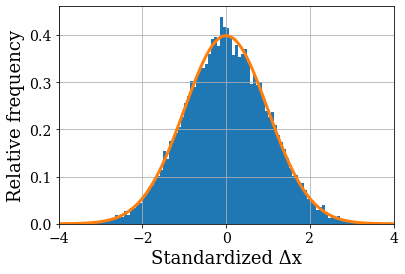

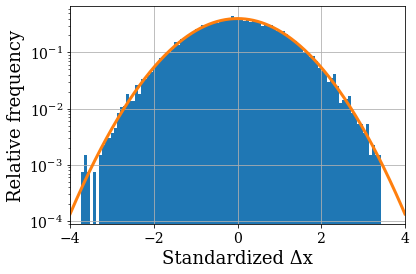

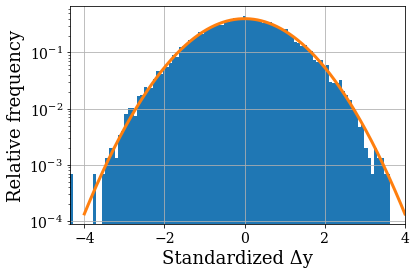

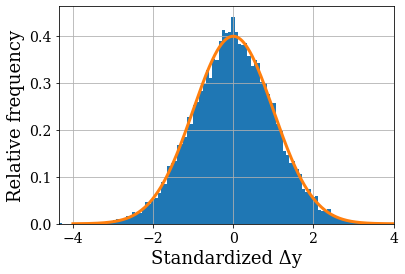

In [10]:
dfk.hist(column = 'Δx_n', density = True, bins = 100)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
plt.xlabel('Standardized Δx', **hfont) ; plt.ylabel('Relative frequency', **hfont)
plt.title('')
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/stand_delta_x.png', dpi = 900, bbox_inches='tight')
plt.show()

dfk.hist(column = 'Δx_n', density = True, log = True, bins = 100)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
plt.xlabel('Standardized Δx', **hfont) ; plt.ylabel('Relative frequency', **hfont)
plt.semilogy()
plt.title('')
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/stand_delta_x_log.png', dpi = 900, bbox_inches='tight')
plt.show()

dfk.hist(column = 'Δy_n', density = True, log = True, bins = 100)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
plt.xlabel('Standardized Δy', **hfont) ; plt.ylabel('Relative frequency', **hfont)
plt.semilogy()
plt.title('')
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/stand_delta_y.png', dpi = 900, bbox_inches='tight')
plt.show()

dfk.hist(column = 'Δy_n', density = True, bins = 100)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
plt.xlabel('Standardized Δy', **hfont) ; plt.ylabel('Relative frequency', **hfont)
plt.title('')
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/stand_delta_y_log.png', dpi = 900, bbox_inches='tight')
plt.show()

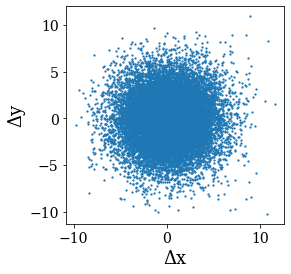

In [11]:
ax = dfk.plot(kind = 'scatter', x = 'Δx', y = 'Δy', s = 1.5)
plt.xlabel('Δx', **hfont) ; plt.ylabel('Δy', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
ax.set_aspect('equal')
plt.savefig('pics/1/scatter_xy.png', dpi = 900, bbox_inches='tight')

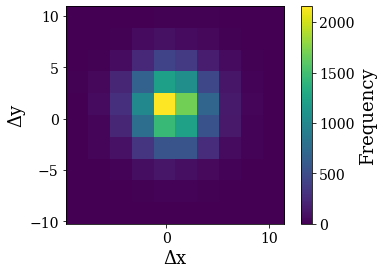

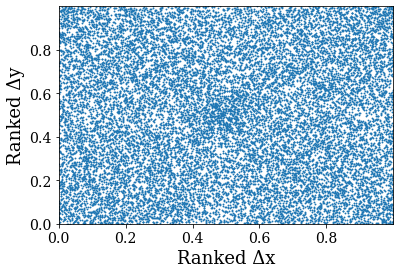

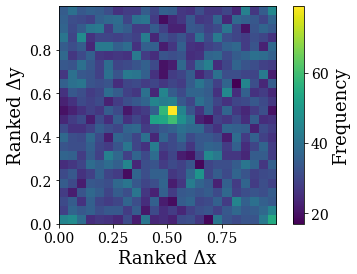

In [12]:
def qrank(series):
    return (series.argsort().argsort() - 0.5) / len(series)

heatmap, xedges, yedges = np.histogram2d(dfk['Δx'], dfk['Δy'], bins=(10, 10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('Δy', **hfont)
plt.xlabel('Δx', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, extent = extent)
cbar = plt.colorbar()
cbar.set_label('Frequency',size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/1/heatmap_xy.png', dpi = 900, bbox_inches='tight')
plt.show()

x_r = qrank(dfk['Δx'])
y_r = qrank(dfk['Δy'])

plt.scatter(x_r, y_r, s = 0.75)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Ranked Δx', **hfont) ; plt.ylabel('Ranked Δy', **hfont)
plt.autoscale(tight = True)
plt.savefig('pics/1/scatter_ranked_xy.png', dpi = 900, bbox_inches='tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(x_r, y_r, bins=(24, 24))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('Ranked Δy', **hfont)
plt.xlabel('Ranked Δx', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, extent = extent)
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/1/heatmap_ranked_xy.png', dpi = 900, bbox_inches='tight')
plt.show()

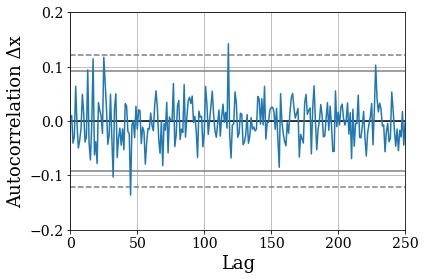

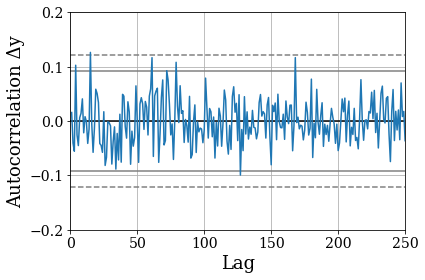

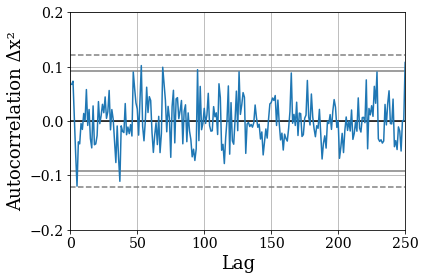

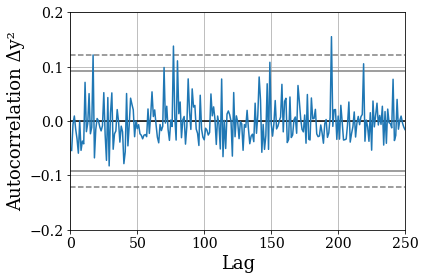

In [13]:
x = pd.plotting.autocorrelation_plot(df_max['Δx']) 
x.plot
plt.axis([0, 250, -0.2, 0.2])
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Lag', **hfont) ; plt.ylabel('Autocorrelation Δx', **hfont)
plt.savefig('pics/1/autcorr_x.png', dpi = 900, bbox_inches='tight')
plt.show()

y = pd.plotting.autocorrelation_plot(df_max['Δy']) 
plt.axis([0, 250, -0.2, 0.2])
y.plot
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Lag', **hfont) ; plt.ylabel('Autocorrelation Δy', **hfont)
plt.savefig('pics/1/autcorr_y.png', dpi = 900, bbox_inches='tight')
plt.show()

x2 = pd.plotting.autocorrelation_plot(df_max['Δx'].apply(lambda x: x ** 2)) 
x2.plot
plt.axis([0, 250, -0.2, 0.2])
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Lag', **hfont) ; plt.ylabel('Autocorrelation Δx²', **hfont)
plt.savefig('pics/1/autcorr_x_sq.png', dpi = 900, bbox_inches='tight')
plt.show()

y2 = pd.plotting.autocorrelation_plot(df_max['Δy'].apply(lambda x: x ** 2)) 
y2.plot
plt.axis([0, 250, -0.2, 0.2])
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Lag', **hfont) ; plt.ylabel('Autocorrelation Δy²', **hfont)
plt.savefig('pics/1/autcorr_y_sq.png', dpi = 900, bbox_inches='tight')
plt.show()

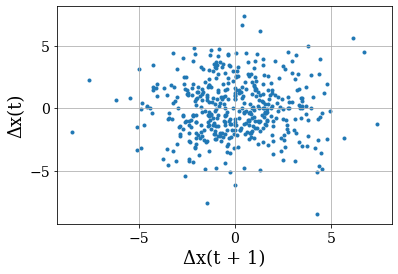

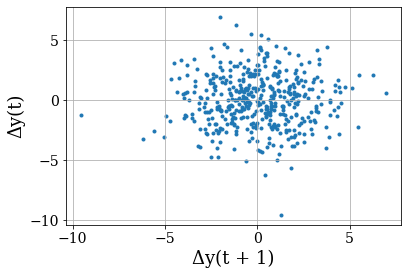

In [14]:
x1 = df_max['Δx'][1:]
x2 = df_max['Δx'][:-1]

plt.scatter(x1, x2, s = 9)
plt.grid(True)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Δx(t + 1)', **hfont) ; plt.ylabel('Δx(t)', **hfont)
plt.savefig('pics/1/scatter_autcorr_x.png', dpi = 900, bbox_inches='tight')
plt.show();

y1 = df_max['Δy'][1:]
y2 = df_max['Δy'][:-1]

plt.scatter(y1, y2, s = 9)
plt.grid(True)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Δy(t + 1)', **hfont) ; plt.ylabel('Δy(t)', **hfont)
plt.savefig('pics/1/scatter_autcorr_y.png', dpi = 900, bbox_inches='tight')
plt.show()

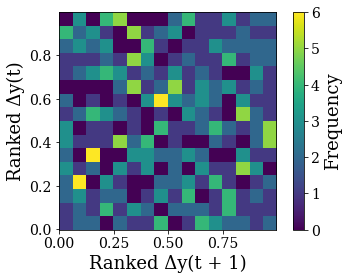

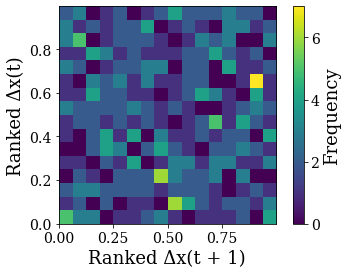

In [15]:
y1_r = qrank(y1)
y2_r = qrank(y2)

heatmap, xedges, yedges = np.histogram2d(y1_r, y2_r, bins=(16, 16))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('Ranked Δy(t)', **hfont)
plt.xlabel('Ranked Δy(t + 1)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, extent=extent)
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/1/heatmap_autcorr_x.png', dpi = 900, bbox_inches='tight')
plt.show()

x1_r = qrank(x1)
x2_r = qrank(x2)

heatmap, xedges, yedges = np.histogram2d(x1_r, x2_r, bins=(16, 16))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('Ranked Δx(t)', **hfont)
plt.xlabel('Ranked Δx(t + 1)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, extent=extent)
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/1/heatmap_autcorr_y.png', dpi = 900, bbox_inches='tight')
plt.show()

In [16]:
shares = ['PFE', 'GME', 'AMZN', 'AZN', 'DDAIF', 'TSLA', 'TYEKF', 'VWDRY', 'DGV2.F', 'RWEOY']   
#Pfizer, GameStop, Amazon, Astrazeneca, Mercedes, Tesla, Thyssenkrupp, Vestas Wind Systems, ABACUS MNG (Kohle), RWE

yf.pdr_override()
raw_data = pdd.get_data_yahoo(shares, start = '2011-02-11', end = '2021-02-11')
data = raw_data['Adj Close']
data

Symbols,PFE,GME,AMZN,AZN,DDAIF,TSLA,TYEKF,VWDRY,DGV2.F,RWEOY
Date,,,,,,,,,,
2011-02-11,12.371558,13.654530,189.250000,16.028015,56.820793,4.650000,40.172020,9.560765,0.959998,48.115273
2011-02-14,12.516098,13.378474,190.419998,15.994948,56.584332,4.616000,40.026123,9.588110,0.977998,47.619099
2011-02-15,12.516098,13.492932,189.029999,16.150364,55.786331,4.568000,40.026123,9.569880,1.001997,47.056774
2011-02-16,12.667210,13.647796,186.619995,16.259491,53.909554,4.946000,40.026123,9.533423,1.067997,46.739227
2011-02-17,12.726344,13.540066,187.759995,16.276028,53.362766,4.720000,39.734314,9.396710,1.061997,46.937695
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,34.919998,63.770000,3352.149902,49.730000,80.629997,852.229980,11.650000,72.260002,0.063500,43.799999
2021-02-08,34.820000,60.000000,3322.939941,50.060001,80.250000,863.419983,12.060000,71.190002,0.060000,42.299999
2021-02-09,34.970001,50.310001,3305.000000,50.410000,79.690002,849.460022,11.950000,69.559998,0.070000,41.310001


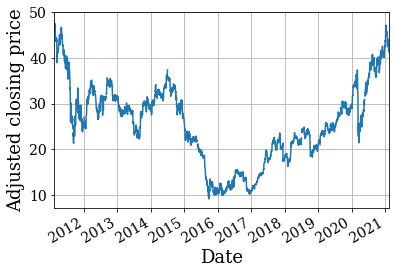

In [17]:
data['RWEOY'].plot()
plt.grid(True)
plt.ylabel('Adjusted closing price', **hfont)
plt.xlabel('Date', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True);
plt.savefig('pics/2/series_adj_RWE.png', dpi = 900, bbox_inches='tight')

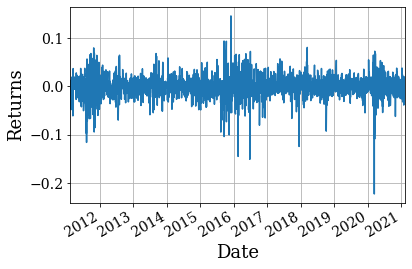

Symbols,PFE,GME,AMZN,AZN,DDAIF,TSLA,TYEKF,VWDRY,DGV2.F,RWEOY
Date,,,,,,,,,,
2011-02-14,0.011548,-0.020634,0.006144,-0.002067,-0.004179,-0.007366,-0.003645,0.002852,0.018405,-0.010420
2011-02-15,0.000000,0.008483,-0.007353,0.009623,-0.014305,-0.010508,0.000000,-0.001905,0.023951,-0.011950
2011-02-16,0.011929,0.011347,-0.012914,0.006712,-0.034813,0.076425,0.000000,-0.003824,0.061798,-0.006794
2011-02-17,0.004647,-0.007956,0.006072,0.001016,-0.010247,-0.047881,-0.007344,-0.014549,-0.005650,0.004228
2011-02-18,-0.009380,-0.008020,-0.006756,0.003240,-0.004032,-0.018119,0.000000,-0.002918,0.027473,0.012526
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,0.000859,0.161048,0.006309,-0.012668,0.022200,0.002628,0.000000,0.002214,-0.047244,0.010959
2021-02-08,-0.002872,-0.062833,-0.008790,0.006592,-0.004735,0.012960,0.033997,-0.015030,-0.058333,-0.035461
2021-02-09,0.004289,-0.192606,-0.005428,0.006943,-0.007027,-0.016434,-0.009205,-0.023433,0.142857,-0.023965


In [18]:
R = data.diff().div(data).dropna()
plt.ylabel('Returns', **hfont)
plt.xlabel('Date', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14);
R['RWEOY'].plot()
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/2/series_returns_RWE.png', dpi = 900, bbox_inches='tight')
plt.show()
R

In [19]:
for share in shares:
    print(share + ' Mean: ' + str(R[share].mean()))
    print(share + ' Var: ' + str(R[share].var()))
    print(share + ' Skew: ' + str(R[share].skew()))
    print(share + ' Kurt: ' + str(R[share].kurtosis() + 3))

R_k = R.sub(R.mean()).divide(R.std())
R_k

PFE Mean: 0.00029438840036398125
PFE Var: 0.00016609049798582353
PFE Skew: -0.23131161784840976
PFE Kurt: 8.782395004673784
GME Mean: -0.0013375074447129515
GME Var: 0.003281118647943683
GME Skew: -9.24417547784071
GME Kurt: 242.4530999071976
AMZN Mean: 0.0007849178090181118
AMZN Var: 0.00038545994266175524
AMZN Skew: -0.11101797184430226
AMZN Kurt: 10.181193430970715
AZN Mean: 0.0002792209924081573
AZN Var: 0.00022968488433315815
AZN Skew: -0.9929217637087685
AZN Kurt: 19.472912468891867
DDAIF Mean: -0.00014473853018416333
DDAIF Var: 0.00046778210784165263
DDAIF Skew: -0.7791448967482782
DDAIF Kurt: 16.376787288961314
TSLA Mean: 0.001128318374687012
TSLA Var: 0.001158948483399683
TSLA Skew: -0.3689948234464391
TSLA Kurt: 9.296362404294204
TYEKF Mean: -0.0007682319395431
TYEKF Var: 0.0009400597118407555
TYEKF Skew: -0.9635916384769264
TYEKF Kurt: 21.23234069211195
VWDRY Mean: -0.00010865128637887076
VWDRY Var: 0.0009082529133003539
VWDRY Skew: -0.7935004169994339
VWDRY Kurt: 13.3781838

Symbols,PFE,GME,AMZN,AZN,DDAIF,TSLA,TYEKF,VWDRY,DGV2.F,RWEOY
Date,,,,,,,,,,
2011-02-14,0.873236,-0.336879,0.272977,-0.154833,-0.186524,-0.249505,-0.093828,0.098237,0.211813,-0.426160
2011-02-15,-0.022843,0.171441,-0.414516,0.616535,-0.654692,-0.341808,0.025056,-0.059605,0.254456,-0.491450
2011-02-16,0.902802,0.221446,-0.697743,0.424429,-1.602935,2.211802,0.025056,-0.123282,0.545448,-0.271471
2011-02-17,0.337707,-0.115551,0.269272,0.048616,-0.467068,-1.439628,-0.214471,-0.479154,0.026864,0.198803
2011-02-18,-0.750664,-0.116665,-0.384092,0.195363,-0.179714,-0.565377,0.025056,-0.093226,0.281531,0.552833
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,0.043816,2.834882,0.281383,-0.854328,1.033135,0.044064,0.025056,0.077078,-0.292943,0.485967
2021-02-08,-0.245682,-1.073581,-0.487712,0.416546,-0.212242,0.347550,1.133873,-0.495120,-0.378205,-1.494564
2021-02-09,0.309991,-3.339120,-0.316457,0.439700,-0.318216,-0.515879,-0.275171,-0.773941,1.168688,-1.004084


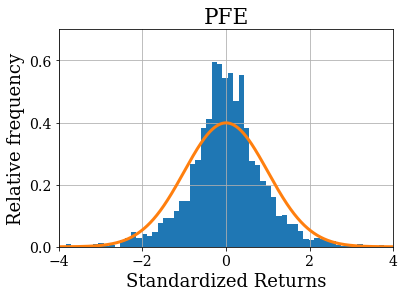

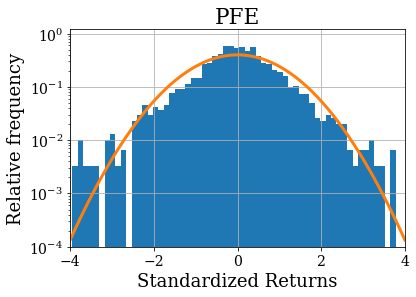

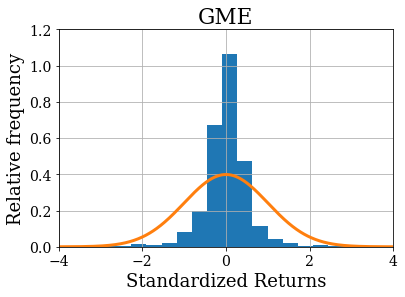

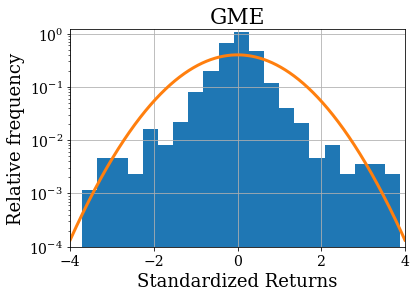

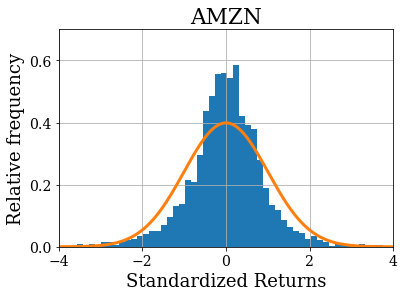

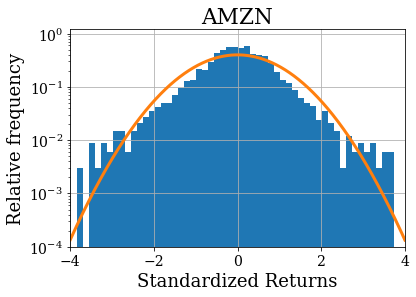

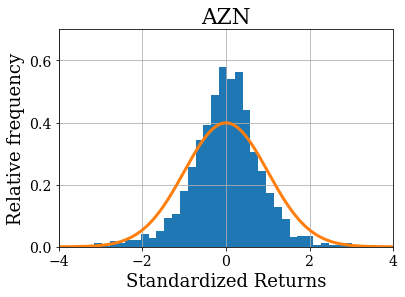

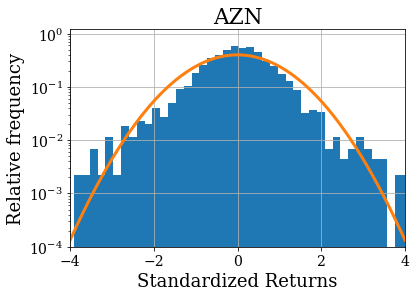

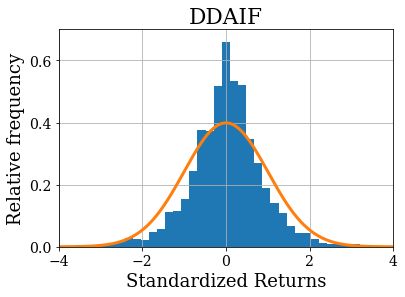

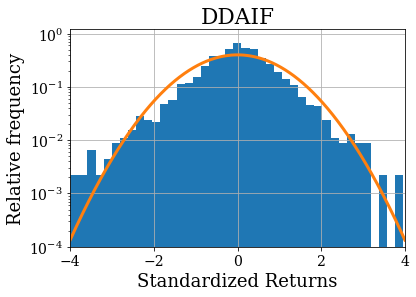

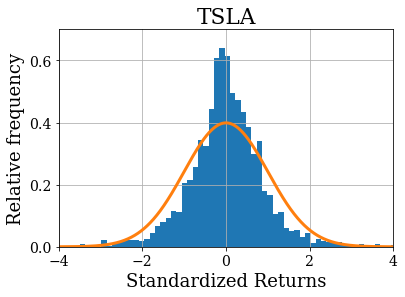

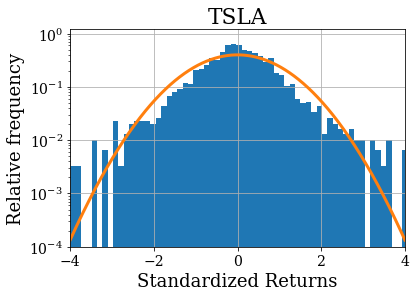

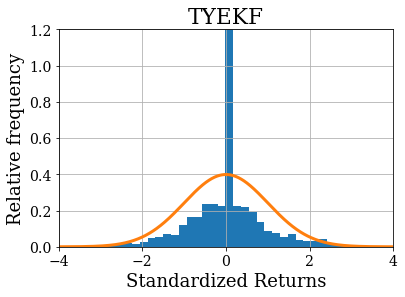

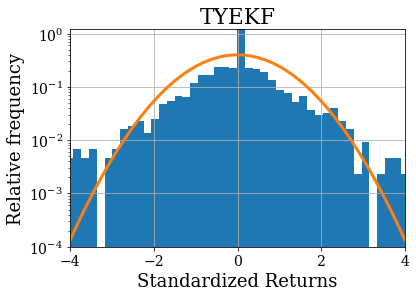

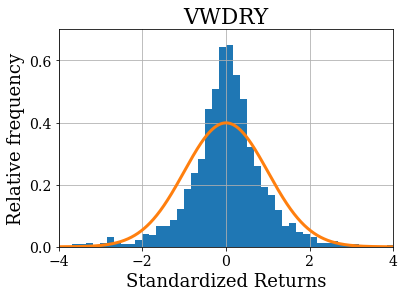

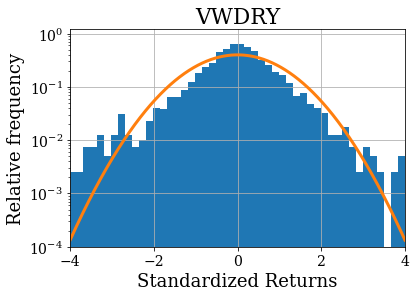

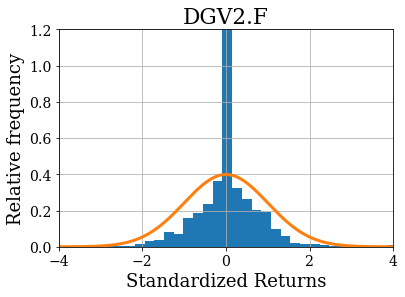

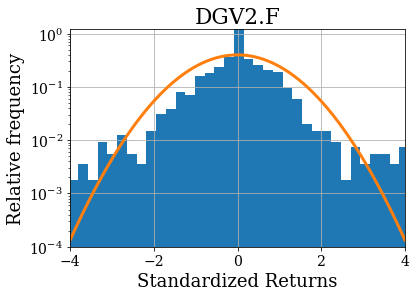

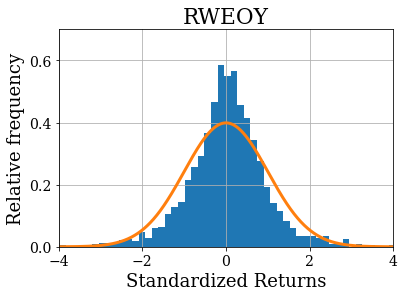

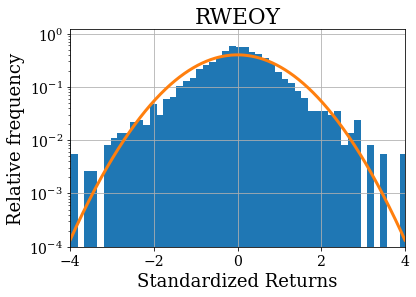

In [20]:
for i, share in enumerate(shares):
    R_k.hist(column = share, density = True, bins = 100)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    if i in [0, 2, 3, 4, 5, 7, 9]:
        plt.axis([-4, 4, 0, 0.7])
    else:
        plt.axis([-4, 4, 0, 1.2])
    plt.title(share, **hfont)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized Returns', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.savefig('pics/2/std_returns_' + share + '.png', dpi = 900, bbox_inches='tight')
    plt.show()

    R_k.hist(column = share, density = True, bins = 100, log = True)
    plt.semilogy()
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.axis([-4, 4, 1e-4, 1.2])
    plt.title(share, **hfont)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized Returns', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.savefig('pics/2/std_returns_log_' + share + '.png', dpi = 900, bbox_inches='tight')
    plt.show()

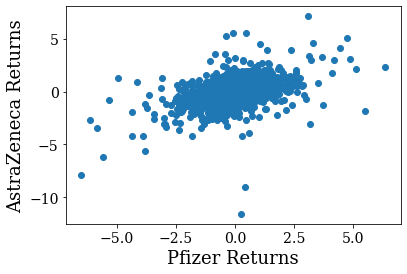

In [21]:
plt.scatter(R_k['PFE'], R_k['AZN'])
plt.ylabel('AstraZeneca Returns', **hfont)
plt.xlabel('Pfizer Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.savefig('pics/2/returns_scatter_PFE_AZN.png', dpi = 900, bbox_inches='tight')
plt.show()

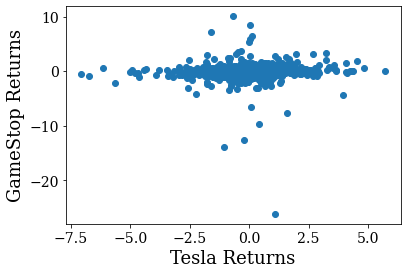

In [22]:
plt.scatter(R_k['TSLA'], R_k['GME'])
plt.ylabel('GameStop Returns', **hfont)
plt.xlabel('Tesla Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.savefig('pics/2/returns_scatter_GME_TSLA.png', dpi = 900, bbox_inches='tight')
plt.show()

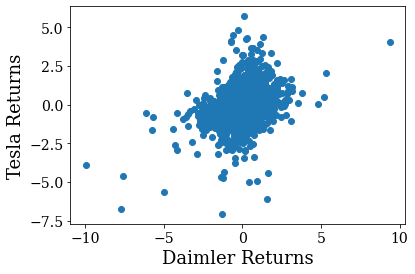

In [23]:
plt.scatter(R_k['DDAIF'], R_k['TSLA'])
plt.ylabel('Tesla Returns', **hfont)
plt.xlabel('Daimler Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.show()

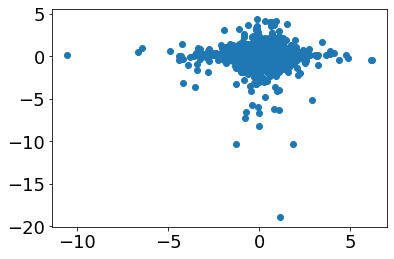

In [24]:
plt.scatter(R_k['VWDRY'], R_k['DGV2.F'])
plt.show()

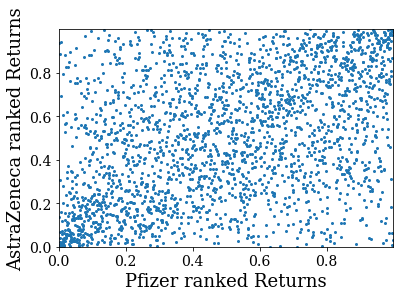

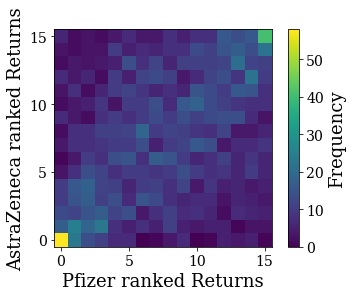

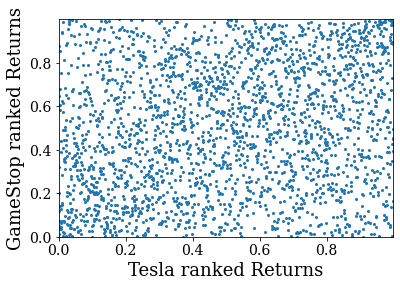

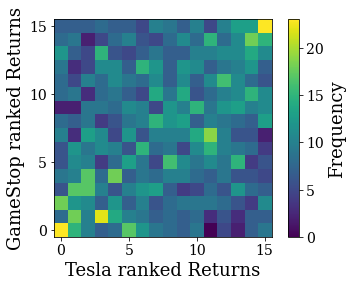

In [25]:
pfe = qrank(R_k['PFE'])
azn = qrank(R_k['AZN'])

plt.scatter(pfe, azn, s = 4)
plt.xlabel('Pfizer ranked Returns', **hfont)
plt.ylabel('AstraZeneca ranked Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(tight = True)
plt.savefig('pics/2/returns_scatter_ranked_PFE_AZN.png', dpi = 900, bbox_inches='tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(pfe, azn, bins=(16, 16))

plt.clf()
plt.xlabel('Pfizer ranked Returns', **hfont)
plt.ylabel('AstraZeneca ranked Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/2/returns_heatmap_ranked_PFE_AZN.png', dpi = 900, bbox_inches='tight')
plt.show()

tesla = qrank(R_k['TSLA'])
gme = qrank(R_k['GME'])

plt.scatter(tesla, gme, s = 4)
plt.ylabel('GameStop ranked Returns', **hfont)
plt.xlabel('Tesla ranked Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(tight = True)
plt.savefig('pics/2/returns_scatter_ranked_GME_TSLA.png', dpi = 900, bbox_inches='tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(tesla, gme, bins=(16, 16))

plt.clf()
plt.ylabel('GameStop ranked Returns', **hfont)
plt.xlabel('Tesla ranked Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/2/returns_heatmap_ranked_GME_TSLA.png', dpi = 900, bbox_inches='tight')
plt.show()

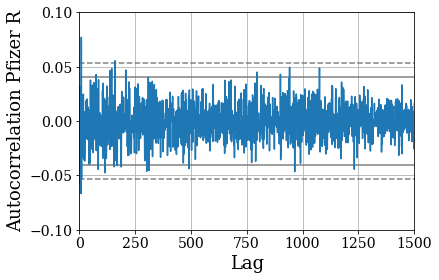

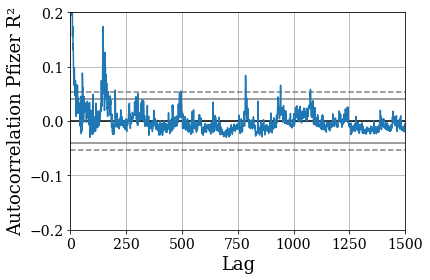

In [26]:
rm = pd.plotting.autocorrelation_plot(R_k['PFE']) 
rm.plot
plt.ylabel('Autocorrelation Pfizer R', **hfont)
plt.xlabel('Lag', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.axis([0, 1500, -0.1, 0.1])
plt.savefig('pics/2/returns_autocorr_PFE.png', dpi = 900, bbox_inches='tight')
plt.show()

rm2 = pd.plotting.autocorrelation_plot(R_k['PFE'].apply(lambda x: x ** 2)) 
rm2.plot
plt.ylabel('Autocorrelation Pfizer R²', **hfont)
plt.xlabel('Lag', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.axis([0, 1500, -0.2, 0.2])
plt.savefig('pics/2/returns_autocorr_PFE_sq.png', dpi = 900, bbox_inches='tight')
plt.show()

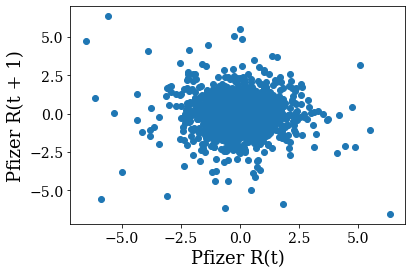

In [27]:
pfe1 = R_k['PFE'][:-1]
pfe2 = R_k['PFE'][1:]

plt.scatter(pfe1, pfe2)
plt.ylabel('Pfizer R(t + 1)', **hfont)
plt.xlabel('Pfizer R(t)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.savefig('pics/2/returns_autocorr_scatter_PFE.png', dpi = 900, bbox_inches='tight')
plt.show()

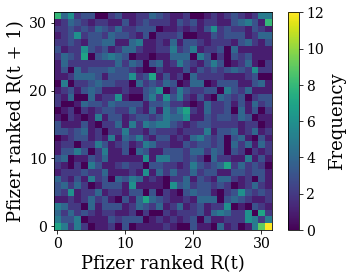

In [28]:
heatmap, xedges, yedges = np.histogram2d(qrank(pfe1), qrank(pfe2), bins=(32, 32))

plt.clf()
plt.ylabel('Pfizer ranked R(t + 1)', **hfont)
plt.xlabel('Pfizer ranked R(t)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/2/returns_autocorr_ranked_heatmap_PFE.png', dpi = 900, bbox_inches='tight')
plt.show()

3654
3654
3632
3654
3223
3633
3654
3633
3633
3633


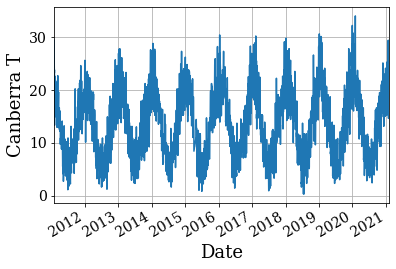

In [29]:
locs = ['Duisburg', 'Munich', 'Lima', 'Houston', 'Anchorage', 'Buenos Aires', 'St. Petersburg', 'Capetown', 'Beijing', 'Canberra']
stations = [Stations(lat = 51.43255447541353, lon = 6.800788835979209), Stations(lat = 48.112136726828126, lon = 11.577648262186404)]
stations.append(Stations(lat = -23.624908208702756, lon = -46.46244886533699))
stations.append(Stations(lat = 29.761421774856345, lon = -95.34205538962071))
stations.append(Stations(lat = 61.21248946290539, lon = -149.82838837782495))
stations.append(Stations(lat = -34.73232248271822, lon = -58.367538730538925))
stations.append(Stations(lat = 59.9214352225393, lon = 30.353551450337235))
stations.append(Stations(lat = -33.988416855015124, lon = 18.52598649283691))
stations.append(Stations(lat = 39.884160925245155, lon = 116.39399713290861))
stations.append(Stations(lat = -35.32332511410454, lon = 149.1169978599246))

for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    print(len(city_data))
    if i == 9:
        city_data.plot()
        plt.ylabel('Canberra T', **hfont)
        plt.xlabel('Date', **hfont)
        plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
        plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
        plt.autoscale(axis = 'x', tight = True) ; plt.grid(True)
        plt.savefig('pics/3/series_canberra.png', dpi = 900, bbox_inches='tight')
        plt.show()

C:\Users\maxim\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\maxim\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
C:\Users\maxim\anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


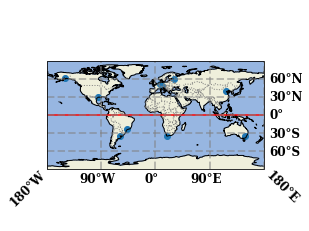

In [30]:
lat = [51.43255447541353, 48.112136726828126, -23.624908208702756, 29.761421774856345, 61.21248946290539, -34.73232248271822, 59.9214352225393, -33.988416855015124, 39.884160925245155, -35.32332511410454]
lon = [6.800788835979209, 11.577648262186404, -46.46244886533699, -95.34205538962071, -149.82838837782495, -58.367538730538925, 30.353551450337235, 18.52598649283691, 116.39399713290861, 149.1169978599246]

ax = plt.axes(projection = ccrs.PlateCarree())
ax.add_feature(cpf.LAND)
ax.add_feature(cpf.OCEAN)
ax.add_feature(cpf.COASTLINE)
ax.add_feature(cpf.BORDERS, linestyle=':', color = 'gray')
ax.scatter(lon, lat, transform = ccrs.PlateCarree())
plt.axis([-180, 180, -180, 180])
plt.hlines(0, -180, 180, colors = 'r')

gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-180,-90, 0, 90, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'fontname': 'DejaVu Serif', 'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'fontname': 'DejaVu Serif', 'weight': 'bold'}
plt.savefig('pics/3/map.png', dpi = 900, bbox_inches='tight')
plt.show()

In [31]:
for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    print(locs[i] + ' Mean: ' + str(city_data.mean()))
    print(locs[i] + ' Var: ' + str(city_data.var()))
    print(locs[i] + ' Skew: ' + str(city_data.skew()))
    print(locs[i] + ' Kurtosis: ' + str(city_data.kurtosis() + 3))

Duisburg Mean: 11.663163656267093
Duisburg Var: 43.379053333734944
Duisburg Skew: 0.03816181128038484
Duisburg Kurtosis: 2.461688348909456
Munich Mean: 10.665790914066783
Munich Var: 58.63771800280827
Munich Skew: -0.05622645528022202
Munich Kurtosis: 2.2731664379959278
Lima Mean: 20.34474118942727
Lima Var: 11.981823067121484
Lima Skew: -0.2323397855339267
Lima Kurtosis: 2.7812969642213154
Houston Mean: 21.859038089089697
Houston Var: 47.11007811866475
Houston Skew: -0.7174806876082429
Houston Kurtosis: 2.708396696809906
Anchorage Mean: 3.1095873409866575
Anchorage Var: 99.05301482034884
Anchorage Skew: -0.3872889767720152
Anchorage Kurtosis: 2.269838903233234
Buenos Aires Mean: 17.40578034682082
Buenos Aires Var: 35.47785754755416
Buenos Aires Skew: -0.03674742865427825
Buenos Aires Kurtosis: 2.250152090397911
St. Petersburg Mean: 6.635012386457447
St. Petersburg Var: 85.94732555739067
St. Petersburg Skew: -0.26009200210671346
St. Petersburg Kurtosis: 2.612176715967987
Capetown Mean:

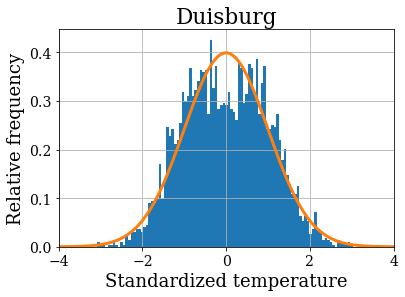

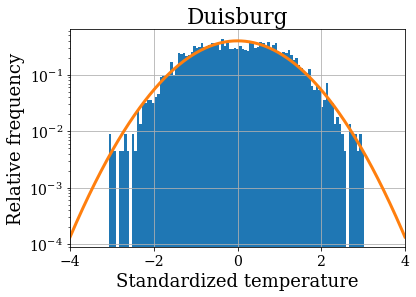

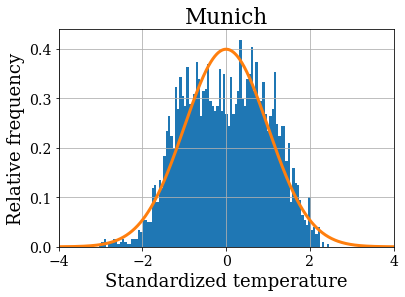

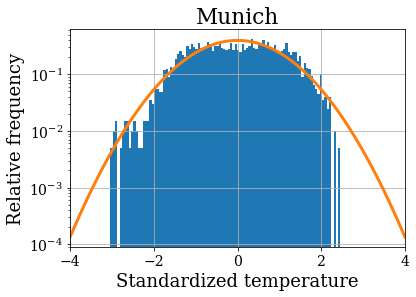

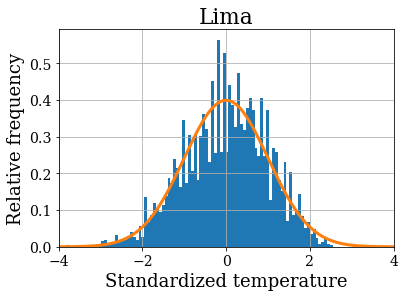

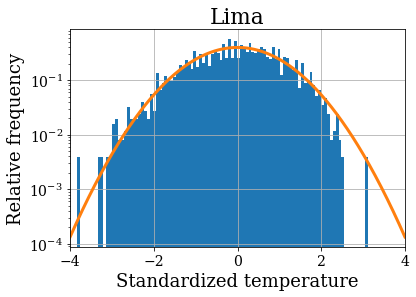

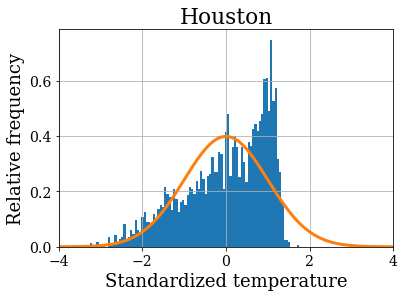

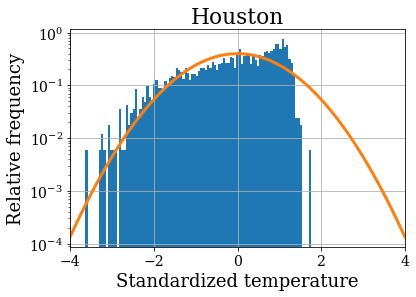

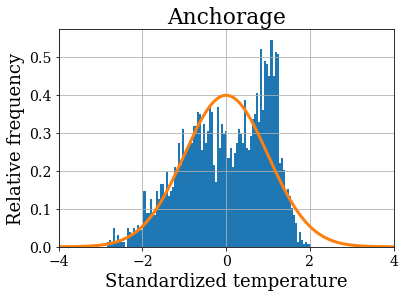

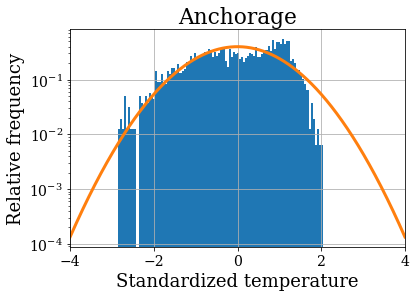

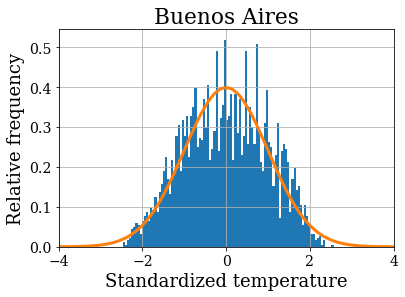

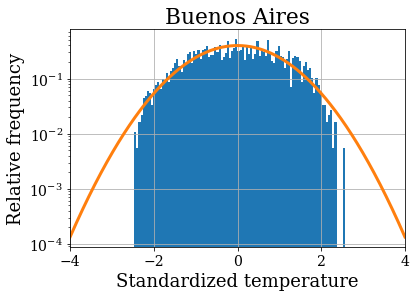

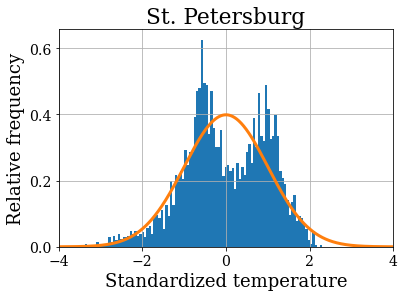

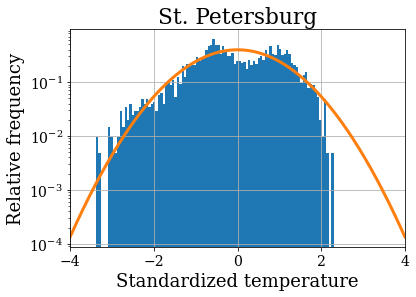

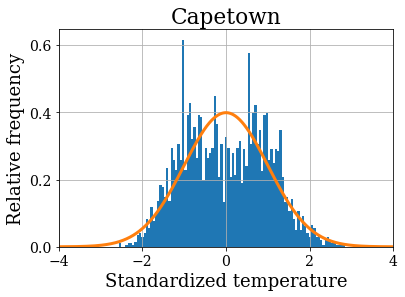

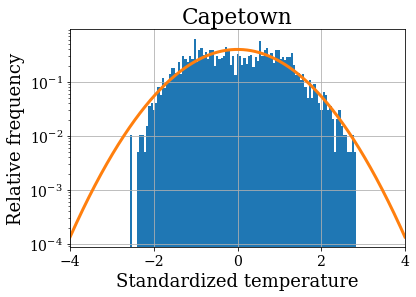

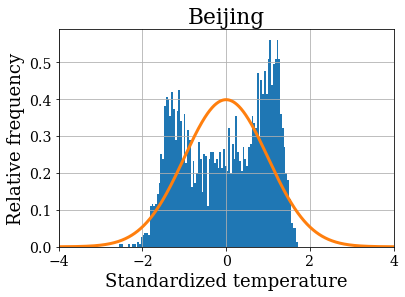

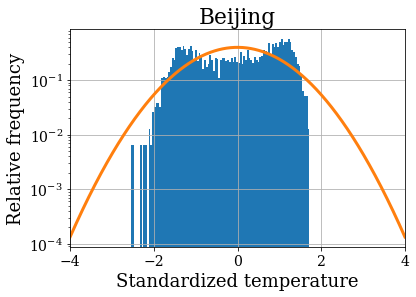

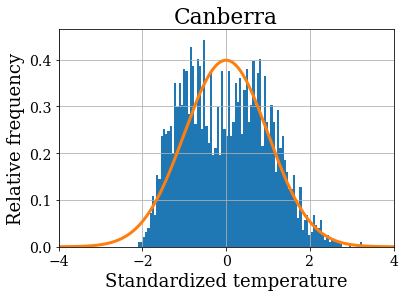

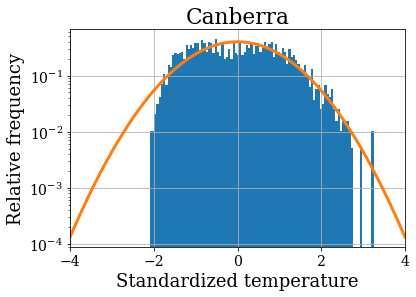

In [32]:
for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    data_n = city_data.sub(city_data.mean()).div(city_data.std())
    data_n.hist(density = True, bins = 100)
    plt.title(locs[i], **hfont)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized temperature', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.autoscale(axis = 'x', tight = True)
    plt.savefig('pics/3/std_temp_' + locs[i] + '.png', dpi = 900, bbox_inches = 'tight')
    plt.show()
    
    data_n.hist(density = True, bins = 100, log = True)
    plt.semilogy()
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.title(locs[i], **hfont)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized temperature', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.autoscale(axis = 'x', tight = True)
    plt.savefig('pics/3/std_temp_log_' + locs[i] + '.png', dpi = 900, bbox_inches = 'tight')
    plt.show()

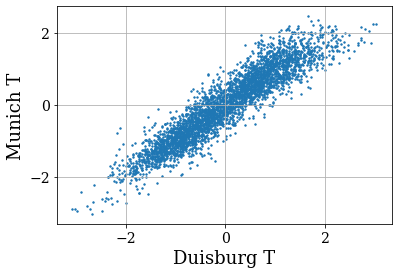

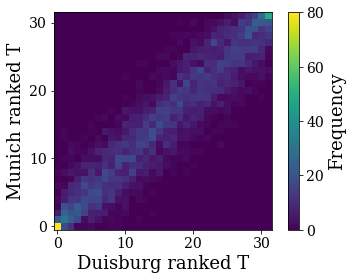

In [33]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_n1 = city_data1.sub(city_data1.mean()).div(city_data1.std())

station2 = stations[1].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
data_n2 = city_data2.sub(city_data2.mean()).div(city_data2.std())

plt.scatter(data_n1, data_n2, s = 2)
plt.ylabel('Munich T', **hfont)
plt.xlabel('Duisburg T', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_scatter_munich_duisburg.png', dpi = 900, bbox_inches = 'tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('Munich ranked T', **hfont)
plt.xlabel('Duisburg ranked T', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/3/temp_heatmap_ranked_munich_duisburg.png', dpi = 900, bbox_inches = 'tight')
plt.show()

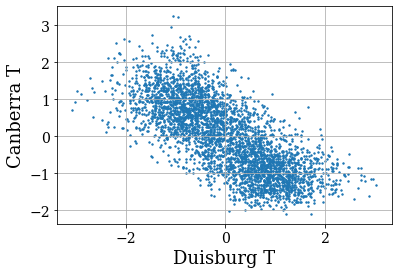

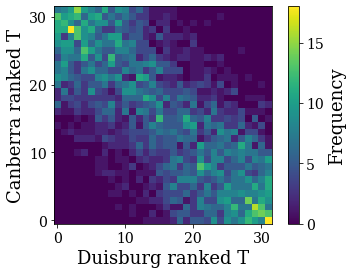

In [34]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_n1 = city_data1.sub(city_data1.mean()).div(city_data1.std())

station2 = stations[9].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
data_n2 = city_data2.sub(city_data2.mean()).div(city_data2.std())

for i in range(len(data_n1) - len(data_n2)):
    c = int(np.random.random() * len(data_n1))
    data_n1 = data_n1.drop(data_n1.index[c])
    
plt.scatter(data_n1, data_n2, s = 2)
plt.ylabel('Canberra T', **hfont)
plt.xlabel('Duisburg T', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_scatter_canberra_duisburg.png', dpi = 900, bbox_inches = 'tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('Canberra ranked T', **hfont)
plt.xlabel('Duisburg ranked T', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/3/temp_heatmap_ranked_canberra_duisburg.png', dpi = 900, bbox_inches = 'tight')
plt.show()

time
2011-02-01    0.368385
2011-02-02    0.788106
2011-02-03    1.426083
2011-02-04    0.754528
2011-02-05    0.955995
                ...   
2021-01-28    1.123883
2021-01-29    1.039939
2021-01-30    0.334807
2021-01-31    0.082974
2021-02-01    0.469118
Name: tavg, Length: 3633, dtype: float64


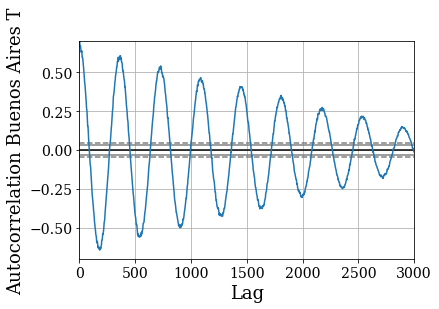

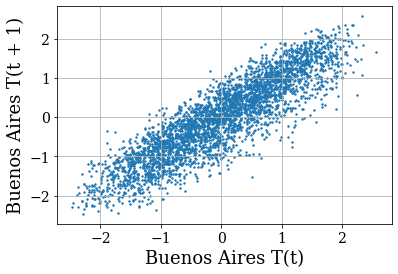

In [35]:
station1 = stations[5].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_n1 = city_data1.sub(city_data1.mean()).div(city_data1.std())
d1 = data_n1[:-1]
d2 = data_n1[1:]

print(data_n1)

d3 = pd.plotting.autocorrelation_plot(data_n1) 
d3.plot
plt.ylabel('Autocorrelation Buenos Aires T', **hfont)
plt.xlabel('Lag', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.axis([0, 3000, -0.7, 0.7])
plt.savefig('pics/3/temp_autocorr_buenos_aires.png', dpi = 900, bbox_inches = 'tight')
plt.show()

plt.scatter(d1, d2, s = 2)
plt.ylabel('Buenos Aires T(t + 1)', **hfont)
plt.xlabel('Buenos Aires T(t)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_scatter_autocorr_buenos_aires.png', dpi = 900, bbox_inches = 'tight')
plt.show()

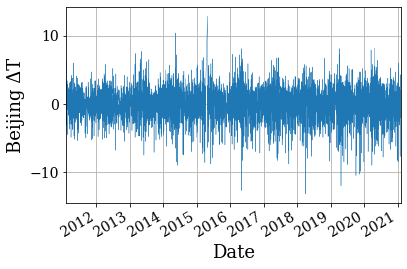

In [36]:
station1 = stations[8].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_dff = city_data1.diff()

data_dff.plot(linewidth = 0.4)
plt.ylabel('Beijing ΔT', **hfont)
plt.xlabel('Date', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True) ; plt.grid(True)
plt.savefig('pics/3/temp_diff_autocorr_beijing.png', dpi = 900, bbox_inches = 'tight')
plt.show()

In [37]:
for i, st in enumerate(stations):
    station1 = st.fetch(1)
    raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data1 = raw_data1.fetch()
    city_data1 = raw_data1['tavg']
    data_dff = city_data1.diff()

    print(locs[i] + ' Mean: ' + str(data_dff.mean()))
    print(locs[i] + ' Var: ' + str(data_dff.var()))
    print(locs[i] + ' Skew: ' + str(data_dff.skew()))
    print(locs[i] + ' Kurtosis: ' + str(data_dff.kurtosis() + 3))

Duisburg Mean: 0.001532986586367355
Duisburg Var: 4.930517912178297
Duisburg Skew: -0.12040462139541412
Duisburg Kurtosis: 3.5920559452726555
Munich Mean: 0.0026279770052012054
Munich Var: 6.098667790640959
Munich Skew: -0.5271317080450719
Munich Kurtosis: 4.127859327876566
Lima Mean: 0.00016524373450839882
Lima Var: 4.216898044312342
Lima Skew: -0.777192607854478
Lima Kurtosis: 4.415989830558375
Houston Mean: -0.007758031442241959
Houston Var: 7.957686800918409
Houston Skew: -1.0056971661200165
Houston Kurtosis: 7.561352267359094
Anchorage Mean: -0.004562383612662924
Anchorage Var: 6.962217613461955
Anchorage Skew: 0.028495140828642036
Anchorage Kurtosis: 6.06774380914832
Buenos Aires Mean: 0.0001651982378854605
Buenos Aires Var: 7.978898347805328
Buenos Aires Skew: -0.46326398414585507
Buenos Aires Kurtosis: 3.3436335584180576
St. Petersburg Mean: -0.002065546681355
St. Petersburg Var: 5.614207853553705
St. Petersburg Skew: 0.020356756311479776
St. Petersburg Kurtosis: 4.411775452299

3654
3654


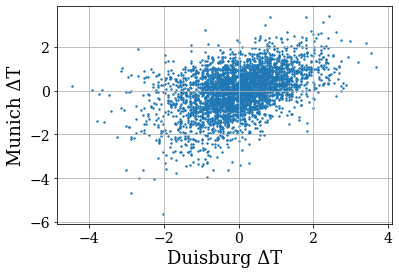

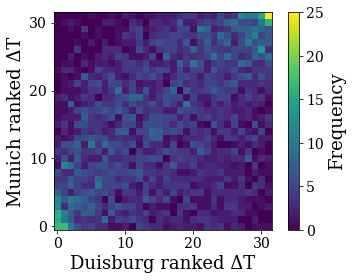

In [38]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
city_data = city_data1.diff()
data_n1 = city_data.sub(city_data.mean()).div(city_data.std())
print(len(data_n1))

station2 = stations[1].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
city_data_ = city_data2.diff()
data_n2 = city_data_.sub(city_data_.mean()).div(city_data_.std())
print(len(data_n2))

plt.scatter(data_n1, data_n2, s = 2)
plt.ylabel('Munich ΔT', **hfont)
plt.xlabel('Duisburg ΔT', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_diff_scatter_munich_duisburg.png', dpi = 900, bbox_inches = 'tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('Munich ranked ΔT', **hfont)
plt.xlabel('Duisburg ranked ΔT', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/3/temp_diff_ranked_heatmap_munich_duisburg.png', dpi = 900, bbox_inches = 'tight')
plt.show()

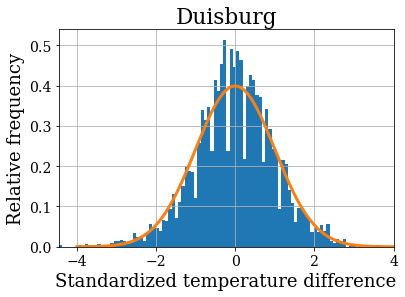

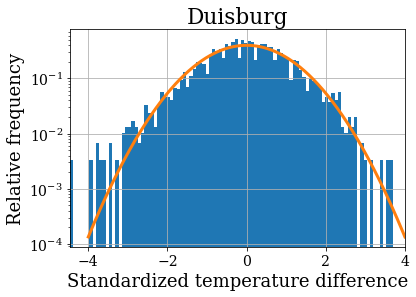

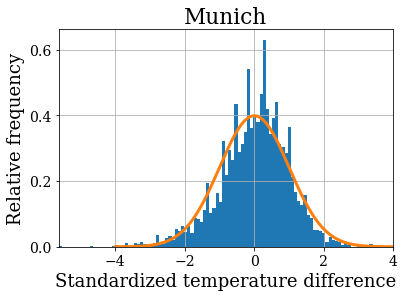

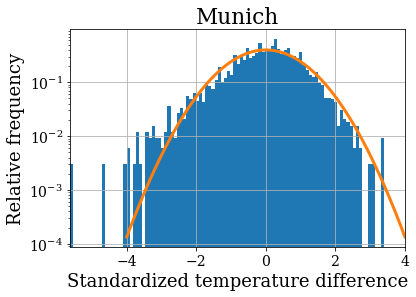

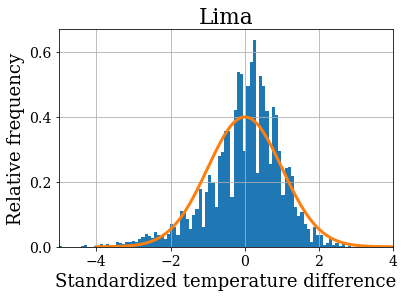

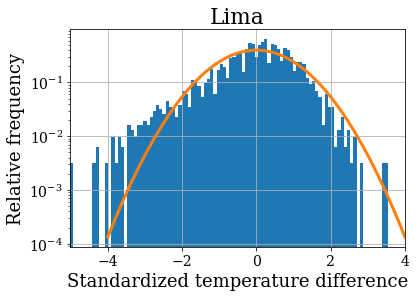

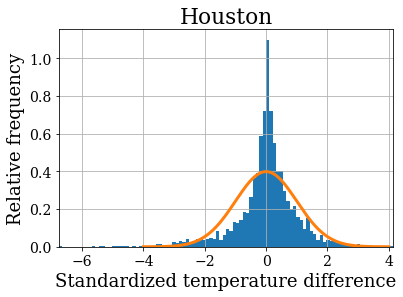

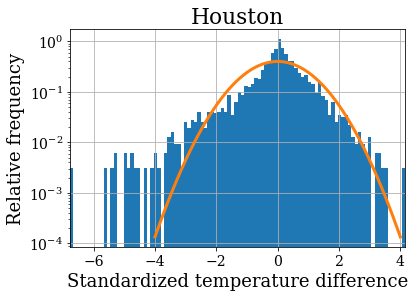

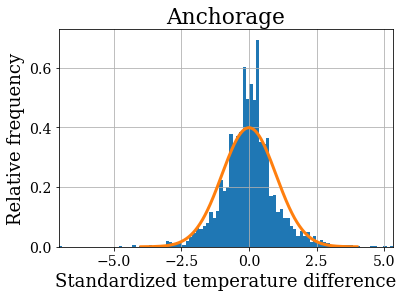

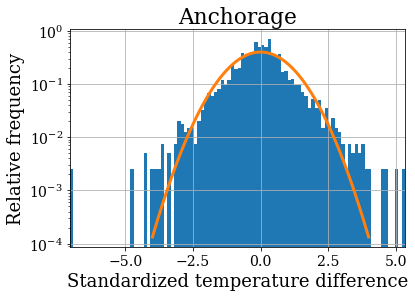

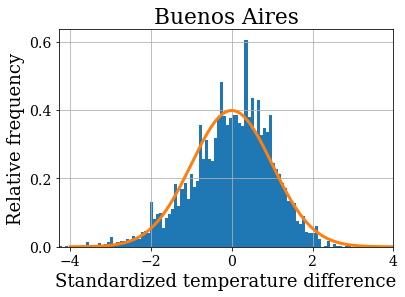

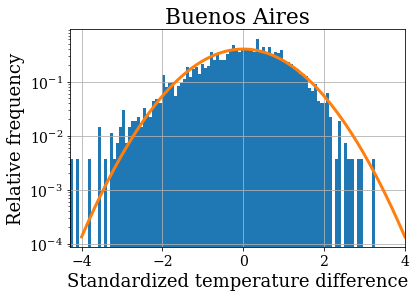

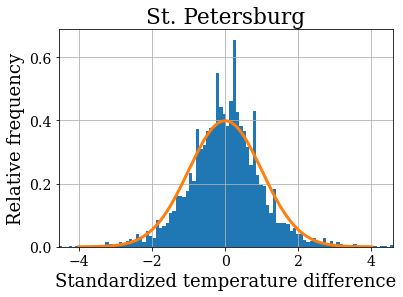

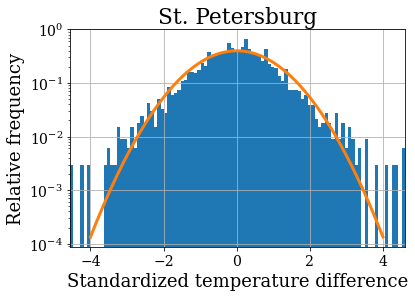

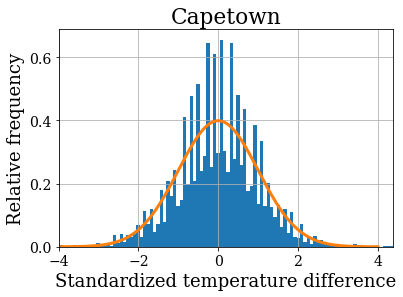

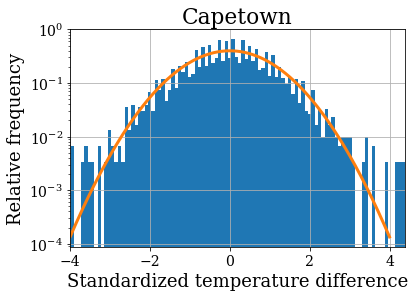

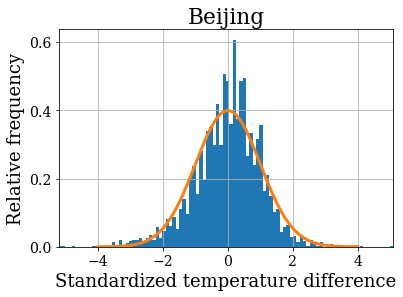

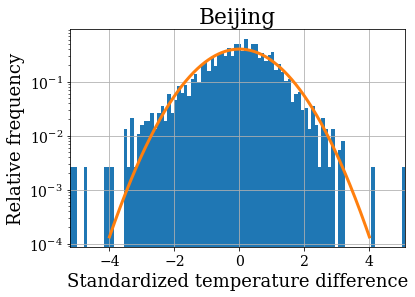

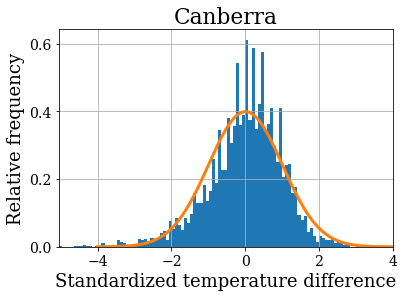

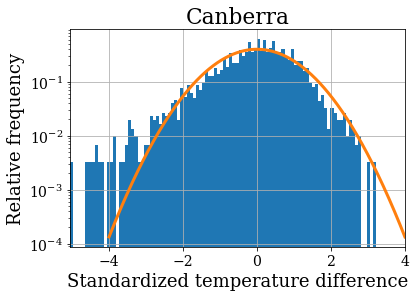

In [39]:
for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    city_data = city_data.diff()
    data_n = city_data.sub(city_data.mean()).div(city_data.std())
    data_n.hist(density = True, bins = 100)
    plt.title(locs[i], **hfont)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized temperature difference', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.autoscale(axis = 'x', tight = True)
    plt.savefig('pics/3/std_temp_diff_' + locs[i] + '.png', dpi = 900, bbox_inches = 'tight')
    plt.show()
    
    data_n.hist(density = True, bins = 100, log = True)
    plt.semilogy()
    plt.title(locs[i], **hfont)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized temperature difference', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.autoscale(axis = 'x', tight = True)
    plt.savefig('pics/3/std_temp_diff_log_' + locs[i] + '.png', dpi = 900, bbox_inches = 'tight')
    plt.show()

3654
3633


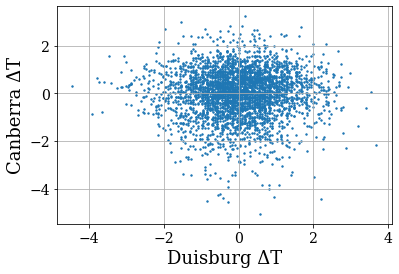

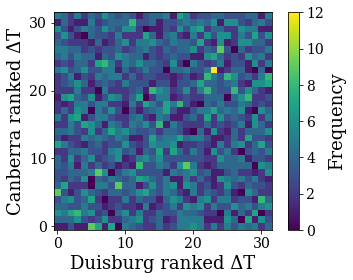

In [40]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
city_data = city_data1.diff()
data_n1 = city_data.sub(city_data.mean()).div(city_data.std())
print(len(data_n1))

station2 = stations[9].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
city_data_ = city_data2.diff()
data_n2 = city_data_.sub(city_data_.mean()).div(city_data_.std())
print(len(data_n2))

for i in range(len(data_n1) - len(data_n2)):
    c = int(np.random.random() * len(data_n1))
    data_n1 = data_n1.drop(data_n1.index[c])

plt.scatter(data_n1, data_n2, s = 2)
plt.ylabel('Canberra ΔT', **hfont)
plt.xlabel('Duisburg ΔT', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_diff_scatter_canberra_duisburg.png', dpi = 900, bbox_inches = 'tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('Canberra ranked ΔT', **hfont)
plt.xlabel('Duisburg ranked ΔT', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/3/temp_diff_heatmap_ranked_canberra_duisburg.png', dpi = 900, bbox_inches = 'tight')
plt.show()

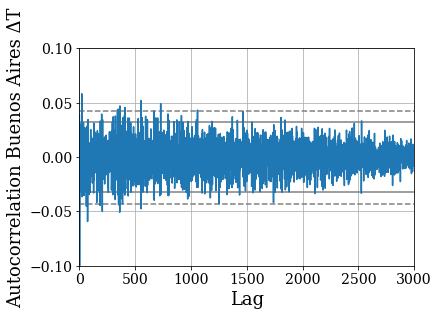

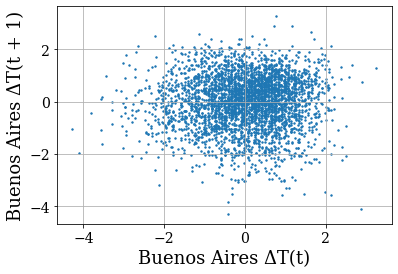

2 -0.28870930398557587


In [41]:
station1 = stations[5].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
city_data = city_data1.diff()
data_n1 = city_data.sub(city_data.mean()).div(city_data.std()).dropna()

d34 = pd.plotting.autocorrelation_plot(data_n1) 
d34.plot
plt.ylabel('Autocorrelation Buenos Aires ΔT', **hfont)
plt.xlabel('Lag', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.axis([0, 3000, -0.1, 0.1])
plt.savefig('pics/3/temp_diff_autocorr_buenos_aires.png', dpi = 900, bbox_inches = 'tight')
plt.show()

d1 = data_n1[:-1]
d2 = data_n1[1:]

plt.scatter(d1, d2, s = 2)
plt.ylabel('Buenos Aires ΔT(t + 1)', **hfont)
plt.xlabel('Buenos Aires ΔT(t)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_diff_autocorr_scatter_buenos_aires.png', dpi = 900, bbox_inches = 'tight')
plt.show()

def aut(x):
    return data_n1.autocorr(lag = x)

minv = 1
idmin = 0
for i in range(1, 3001):
    v = aut(i)
    if minv > v:
        minv = v
        idmin = i
print(idmin, minv)